In [1]:
import torch
from torch import nn, optim
import mltools

In [2]:
class TransformerCSCModel(nn.Module):
    '''Transformer 分类模型'''

    def __init__(self, *args, tokenizer_size, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.embedding = nn.Embedding(num_embeddings=tokenizer_size, embedding_dim=256, padding_idx=1)  # 定义嵌入层
        encode_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
        self.hidden_layer = nn.TransformerEncoder(encode_layer, num_layers=6)  # 定义隐藏层
        self.output_layer = nn.Linear(256, 2)  # 定义输出层

    def forward(self, x):
        '''前向传播'''
        x = self.embedding(x)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = self.hidden_layer(x)  # x形状为(批量大小, 时间步数, 隐藏大小)
        x = self.output_layer(x[:, 0, :])  # 它的输出形状是(批量大小, 输出大小)
        return x

In [3]:
class TransformerCSC(mltools.MachineLearning):
    '''Transformer 文本分类学习'''

    @mltools.MachineLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = self.tokenizer(x)
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = self.tokenizer(x)
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.MachineLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = self.tokenizer(x)
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.MachineLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x, y = x[:10], y[:10]
        X = self.tokenizer(x)
        X = X.to(self.device)
        y = y.to(self.device)
        y_pred = self.model(X)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {content}')

In [4]:
train_iter, val_iter, test_iter, tokenizer = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')  # 加载词表，数据集


def tokenize(text):
    return tokenizer(text, max_length=200)

model = TransformerCSCModel(tokenizer_size=len(tokenizer))  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1)  # 设置优化器
legend = ['train loss', 'val loss', 'val acc']  # 设置图例
device = torch.device('cuda')  # 设置设备
ml = TransformerCSC(train_iter, val_iter, test_iter, tokenizer=tokenize, model=model, loss=loss, optimizer=optimizer, legend=legend, device=device)

2025-06-15 12:26:46,059 - INFO: train loss 0.801, val loss 0.732, val acc 0.304, 68.7 sec/epoch on cuda


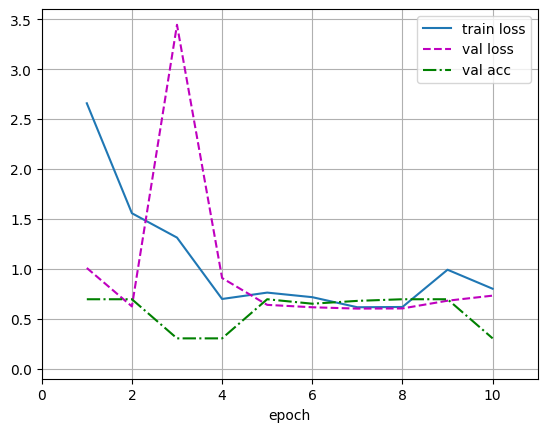

In [5]:
ml.train(num_epochs=10)  # 训练

In [6]:
ml.test()  # 测试

2025-06-15 12:26:49,065 - INFO: test acc 0.322


In [7]:
ml.predict()  # 预测

预测值 0, 真实值 1, 数据 标准间面积大，但房间陈旧，有些味道。早餐人多时很混乱。
预测值 0, 真实值 1, 数据 绝对是超值的一家酒店.如果不是要求豪华享受,这家酒店的每一部分都绝对可以令人满意.(AvlNtTy)
预测值 0, 真实值 1, 数据 酒店服务态度绝对是好的，大堂小姐会提醒天冷加衣服，早餐的时候主动为客户提供及时周到的服务，很不错。但是酒店装修一般，还有隔音效果不好。不过总的来说还是比较满意的，至少在我已经住过的酒店当中算是好的了。
预测值 0, 真实值 0, 数据 酒店很新并且很有档次和气派，主楼设计和总体设备设施让人感觉非常不错，周遍是一个广场，视线很开阔。但令人非常愤怒的是，为什么通过携程网预订的客房总是常常被安排在不方正的――床和电视机等客房设施都歪歪扭扭摆放的房间（1710房），真的不止一个客人反映这样的问题，携程网的客人一样付钱消费，为什么会受到不公正的待遇？！难道就是因为那40元/间.晚的返佣费给的不甘心？！酒店在争创五星，应该做到给每一位客人提供最优质最满意的服务，否则受到伤害的顾客永不会再光顾，何况现在酒店这么多……望酒店领导能重视这个问题，解决这个尴尬的局面，真正让酒店在硬件和软件都上五星。
预测值 0, 真实值 0, 数据 管理混乱各种设施不到位进了房间发现未打扫卫生又换了房间但卫生还是感觉不好没有一次性拖鞋等很不方便很失望好不容易捱到早上立马换酒店！
预测值 0, 真实值 1, 数据 服务还可以，饭菜价格也挺公道，就是早餐品种少了点，没啥吃的，而且都是冷的。被子没洗干净吧，枕头和被子都是臭的，没法睡
预测值 0, 真实值 1, 数据 首先非常不好找，我们在那个立交桥附近转了四、五圈，打了N个电话才终于到达了。房间是不错，空间很大，设施也比较新。可能是刚开业没多久得缘故吧。开始服务员的服务水平并不是特别高，搞checkin就等了20分钟。还有房间浴室全部是木质的，给人一种焕然一新的感觉。但是挂毛巾和衣服的设施太少了。餐厅的服务员的服务态度和精神可嘉。赞！
预测值 0, 真实值 1, 数据 早餐食物相当一般，跟其服务水准不相符，希望进一步改进。
预测值 0, 真实值 1, 数据 我时12月20号入住5206房间，是行政大床间，我每次通过携程都是订一样的房型。房间是套房的格局。够5星级的标准。确定是宽带每隔两个小时就要断线，